In [1]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### pandas and numpy
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt

### punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import en_core_web_sm
nlp = en_core_web_sm.load()
import scattertext as st

### textblob
from textblob import TextBlob

### countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

### gensim
import gensim
from gensim import models

### PCA
import random
from adjustText import adjust_text

### plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

###time
from datetime import datetime

# 1. DATA CLEANING

In [2]:
###' ################################################################################
###'
###' Data Load 
###'
###'

### daata load
df= pd.read_csv("data/7_124(2020-2024).csv")
df.head(5)


df_S = df[['Authors','Title','Year','Volume','Abstract']]
df_clean = df_S.dropna(subset = ['Title'])

#spell = SpellChecker()
#df_clean['Title_spell'] = df_clean['Title'].map(lambda x: spell.correction(x))
#df_clean['Abstract_spell'] = df_clean['Abstract'].map(lambda x: spell.correction(x))
df_clean.head(5)

,Authors,Title,Year,Volume,Abstract
0,Domingue B.W.; Kanopka K.; Stenhaug B.; Soland...,Variation in Respondent Speed and its Implicat...,2021,58.0,The more frequent collection of response time ...
1,Baldwin P.; Yaneva V.; Mee J.; Clauser B.E.; H...,Using Natural Language Processing to Predict I...,2021,58.0,"In this article, it is shown how item text can..."
2,Lim H.; Choe E.M.; Han K.T.,A Residual-Based Differential Item Functioning...,2022,59.0,Differential item functioning (DIF) of test it...
3,Liao X.; Bolt D.M.; Kim J.-S.,Curvilinearity in the Reference Composite and ...,2024,NaN,Item difficulty and dimensionality often corre...
4,Kim S.Y.; Lee W.-C.,Several Variations of Simple-Structure MIRT Eq...,2023,60.0,The current study proposed several variants of...


In [3]:
###' ################################################################################
###'
###' Function for Deleteing Punctuations and StopWords
###'
###'

### define fuction
def rem_punc_stop(text):
    
    # when text is None
    if text is None:  
        return None
    
    # add more stop words
    stop_words = STOP_WORDS 
    nlp.Defaults.stop_words |= {"use","education","measurement","model","Education","Measurement","Model"}
    
    punc = set(punctuation)
    
    
    # remove the punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])                                                               

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # lemmatize
    text_lemma = " ".join([word.lemma_ for word in doc])
    
    # extract words from processed text 
    spacy_words = text_lemma.split()
    spacy_words_1 = [word for word in spacy_words if not word.startswith(".")]
    spacy_words_2 = [word for word in spacy_words_1 if not word.startswith(".")]
    
    
    # filter out words 
    no_stop = [word for word in spacy_words_2 if word not in stop_words]
    
    # return
    return no_stop

In [4]:
###' ################################################################################
###'
###' Apply the Function and Tokenize Text Column
###'
###'

# tokenize
#df_clean['A_tokens'] = df_clean['Abstract_spell'].map(lambda x: rem_punc_stop(x))
df_clean['T_tokens_'] = df_clean['Title'].map(lambda x: rem_punc_stop(x))
df_clean['T_tokens'] = df_clean['T_tokens_'].map(lambda tokens: [token.lower() for token in tokens])

#df_clean['A_tokens']
df_clean['T_tokens']

0      [variation, respondent, speed, implications, e...
1      [natural, language, processing, predict, item,...
2      [residualbased, differential, item, functionin...
3      [curvilinearity, reference, composite, practic...
4          [variations, simplestructure, mirt, equating]
                             ...                        
119    [link, pseudoequivalent, group, design, method...
120    [integrate, multiple, sources, validity, evide...
121    [statistical, theoreticians, educational, asse...
122    [examine, precision, cut, scores, generalizabi...
123    [bayesian, extension, biweight, huber, weight,...
Name: T_tokens, Length: 124, dtype: object

# 2. WORD CLOUDS

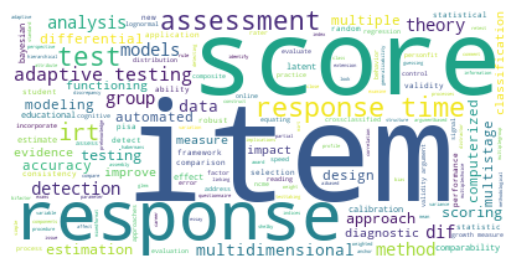

In [5]:
###' ################################################################################
###'
###' VISUALIZATION : Word Cloud
###'
###'

### 2. Title

# apply function to text object
TO_text = ' '.join(df_clean['T_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
TO_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(TO_text)          

# plot 
plt.imshow(TO_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')                       
plt.show()                              

# 3. WORDS FREQUENCY

###' ################################################################################
###'
###' VISUALIZATION : WORDS COUNT
###' _ unigrams
###'
###'

### join token
#df_clean['A_tokens_join'] = df_clean['A_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")


### most frequent unigrams _____ Abstract one word
countvec = CountVectorizer(min_df = 5, ngram_range=(1,1))
ngrams = countvec.fit_transform(df_clean['A_tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

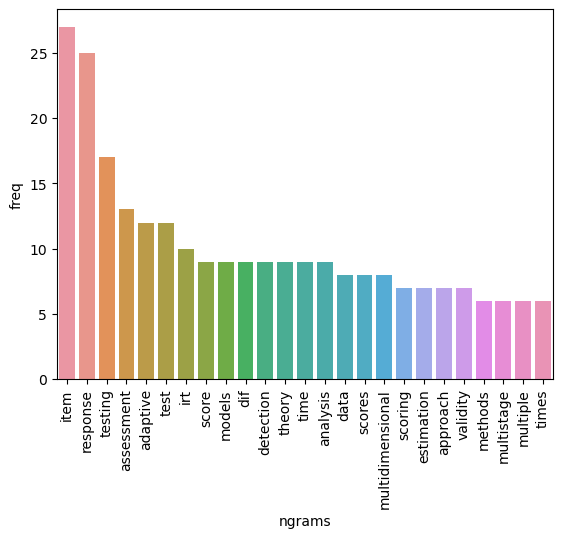

In [6]:
### join token
df_clean['T_tokens_join'] = df_clean['T_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")

### most frequent unigrams  _____ Title one word
countvec = CountVectorizer(min_df = 5, ngram_range=(1,1))
ngrams = countvec.fit_transform(df_clean['T_tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

### most frequent bigrams _____ Abstract two words
countvec = CountVectorizer(min_df = 5, ngram_range=(2,3))
ngrams = countvec.fit_transform(df_clean['A_tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

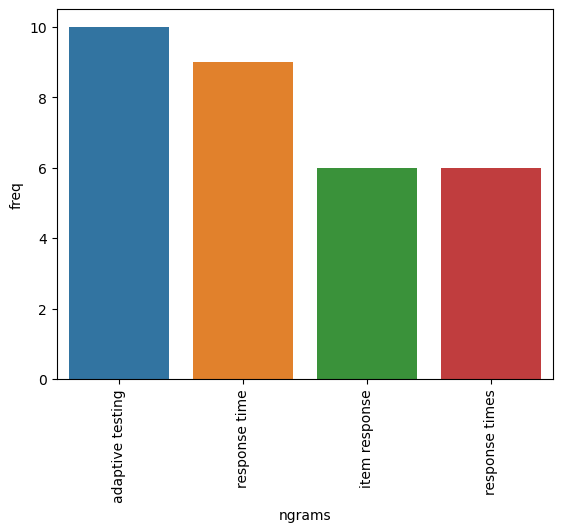

In [7]:
### most frequent bigrams _____ Abstract two words
countvec = CountVectorizer(min_df = 5, ngram_range=(2,3))
ngrams = countvec.fit_transform(df_clean['T_tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

# 4. TOPIC MODELING

###' ################################################################################
###'
###' Topic Modeling : TD-IDF Matrix
###'
###'


### 1. Abstract

### create tf-idf matrix
tfidf = TfidfVectorizer(min_df = 5) 
tfidf_mx_a = tfidf.fit_transform(df_clean['A_tokens_join'])



### convert matrix to an arrray and then to a dataframe
tfidf_df_a = pd.DataFrame(data = tfidf_mx_a.toarray(),
                        columns = tfidf.get_feature_names_out())

## sort by term frequency on the first document
tfidf_df_a.T.nlargest(10,0)

###' ################################################################################
###'
###' Topic Modeling : Latent Dirichlet Allocation (LDA)
###'
###'


### define function
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nlda_{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    

# Latent Dirichlet Allocation (LDA)
# ---------------------------------------

# pre-processing
X = df_clean['A_tokens_join']

tf = TfidfVectorizer(tokenizer = rem_punc_stop,
                     token_pattern = None) 

tfidf_mx =  tf.fit_transform(X)

dense_matrix = tfidf_mx.todense()


# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components=5,
                                max_iter=20,  
                                random_state=0) 

# fit LDA model to our dense matrix
lda = lda.fit(numpy.asarray(dense_matrix))

# post-processing
tf_feature_names = tf.get_feature_names_out()

### print top words 
print_top_words(lda, tf_feature_names, 20)

### join
col_names = ['lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4']
topic_dist = lda.transform(tfidf_mx)
topic_dist_lda = pd.DataFrame(lda.transform(tfidf_mx),
                              columns = col_names)


df_clean = df_clean.join(topic_dist_lda)

###' ################################################################################
###'
###' Topic Modeling : on-Negative Matrix Factorization (NMF)
###'
###'


# pre-processing
Y = df_clean['A_tokens_join']

tf = TfidfVectorizer(tokenizer = rem_punc_stop,
                     token_pattern = None) 

tfidf_mx =  tf.fit_transform(Y)
dense_matrix = tfidf_mx.todense()


# initialize LDA and set model parameters
nmf = NMF(n_components=5,  # specify the number of components
          init='random',   # specify the initalization method
          random_state=1)  # set a seed for reproducibility

# fit NMF model to our dense matrix
nmf = nmf.fit(numpy.asarray(dense_matrix))

# post-processing
tf_feature_names = tf.get_feature_names_out()

### print top words 
print_top_words(nmf, tf_feature_names,20)  

### join
col_names2 = ['nmf_0', 'nmf_1', 'nmf_2', 'nmf_3', 'nmf_4']
topic_dist_nmf = pd.DataFrame(nmf.transform(tfidf_mx),
                              columns = col_names2)

df_clean = df_clean.join(topic_dist_nmf)

###' ################################################################################
###'
###' Word Embedding : Word2VecModel
###'
###'


### drop na
tweets_party = df_clean[df_clean['A_tokens'].notna()]

### Train Word2VecModel
model = gensim.models.Word2Vec(df_clean['A_tokens'].tolist(),
                               vector_size = 150, 
                               window = 5, 
                               min_count = 5, 
                               sg = 0, 
                               alpha = 0.025,
                               epochs = 5,
                               seed = 224,
                               batch_words = 10000,
                               workers = 1)

### return list of words
words = list(model.wv.index_to_key)
print(words[0:50]) 

###' ################################################################################
###'
###' Word Embedding : Principal Component Analysis (PCA)
###'
###'


### take random sample
rando = random.sample(list(model.wv.index_to_key), 50) 
X1 = model.wv.__getitem__(rando)

### initalize PCA
pca1 = PCA(n_components=2)
result = pca1.fit_transform(X1)

### convert to dataframe 
result_df = pd.DataFrame(result,                  
                         columns = ['PC1', 'PC2'],
                         index = rando)   

### create scatterplot
sns.scatterplot(x = 'PC1',         # specify x-axis
                y = 'PC2',         # specify y-axis
                data = result_df)  # specify data

### initialize empty list
texts = []

### append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], 
                          result_df.loc[word, 'PC2'], 
                          word, 
                          fontsize = 8))
    
### adjust plot text to prevent overlapping 
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-", 
                              color = 'black', 
                              lw = 0.5))

### plot 
plt.show();

###' ################################################################################
###'
###' Word Embedding : t-SNE
###'
###'


### preprocessing
vector_list = [model.wv.__getitem__(word) for word in words if word in model.wv.index_to_key]
words_filtered = [word for word in words if word in model.wv.index_to_key]
word_vec_zip = zip(words_filtered, vector_list)


### create a dictionary and save as a dataframe
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
word_vec_df.shape


### initialize t-SNE
tsne = TSNE(n_components = 2,  # specify 2 components
            init = 'random',   # set initalization
            random_state = 10, # set seed
            perplexity = 100)  # set preplexity threshold


### subset to only 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])


### figure specifications
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], 
                y = tsne_df[:, 1], 
                alpha = 0.5)


### Convert tsne_df to DataFrame
tsne_df = pd.DataFrame(tsne_df, index=words_filtered[:400], columns=['PC1', 'PC2'])

### Initialize empty list
texts = []

### Append words to list using loop
for word in tsne_df.index:
    texts.append(plt.text(tsne_df.loc[word, 'PC1'], 
                          tsne_df.loc[word, 'PC2'], 
                          word, 
                          fontsize = 8))

### Adjust plot text to prevent overlapping 
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-", 
                              color = 'black', 
                              lw = 0.5))

plt.show()

In [8]:
csv_file_path = 'data/7_output.csv'
df_clean.to_csv(csv_file_path, index=False)